<a href="https://colab.research.google.com/github/Yanina-Kutovaya/GNN/blob/main/notebooks/1_1_GCN_NeighborLoader.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Реализация Graph Convolutional Network (GCN) с Neighborhood Sampling для классификации узлов на датасете Bitcoin-OTC

Задача — предсказать "уровень доверия" пользователей

Признаки узлов/рёбер - синтетические

Небходимо выбрать среду выполнения с GPU: Среда выполнения → Сменить среду выполнения → Графический процессор T4

In [1]:
CHECKPOINT_DIR = '/content/checkpoints'
BEST_MODEL_PATH = '/content/best_model'

In [2]:
import os

os.makedirs(CHECKPOINT_DIR, exist_ok=True)
os.makedirs(BEST_MODEL_PATH, exist_ok=True)

## 1. Установка зависимостей

In [3]:
!nvcc --version

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2024 NVIDIA Corporation
Built on Thu_Jun__6_02:18:23_PDT_2024
Cuda compilation tools, release 12.5, V12.5.82
Build cuda_12.5.r12.5/compiler.34385749_0


* Google Colab иногда возникают проблемы с кэшированием пакетов, поэтому добавлен флаг ```--no-cache-dir ```

In [4]:
install = True
if install:
  # 1. Установка совместимых версий PyTorch и PyG
  !pip install -q torch==2.3.0+cu121 torchvision==0.18.0+cu121 torchaudio==2.3.0+cu121 --extra-index-url https://download.pytorch.org/whl/cu121

  # 2. Установка зависимостей PyG для CUDA 12.1+ (совместимо с 12.5)
  !pip install -q pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv -f https://data.pyg.org/whl/torch-2.3.0+cu121.html --no-cache-dir

  # 3. Установка PyTorch Geometric
  !pip install -q torch-geometric==2.5.3

  # 4. Установка torchmetrics
  !pip install -q torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.0/781.0 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 93.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 95.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.7/23.7 MB 57.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 823.6/823.6 kB 45.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.7/731.7 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 410.6/410.6 MB 1.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 MB 7.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.5/56.5 MB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.2/124.2 MB 7.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.0/196.0 MB 6.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━

### Принудительная перекомпиляция расширений

In [5]:
!python -c "import torch; import torch_geometric; print('Rebuild success')"

Rebuild success


### Проверка окружения

In [6]:
import torch
print(f"PyTorch: {torch.__version__}")          # Должно быть 2.3.0+cu121
print(f"CUDA: {torch.version.cuda}")            # Должно быть 12.1+
print(f"Available: {torch.cuda.is_available()}")# Должно быть True

PyTorch: 2.3.0+cu121
CUDA: 12.1
Available: True


## 2. Импорт библиотек

In [7]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import BitcoinOTC
from torch_geometric.loader import NeighborLoader
from torch_geometric.nn import GCNConv
from torchmetrics.classification import (
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassRecall
)
import matplotlib.pyplot as plt

## 3. Загрузка и подготовка данных

Обработка признаков:

- Нормализация степеней узлов
- Стандартизация признаков рёбер
- Явное преобразование типов данных

In [8]:
dataset = BitcoinOTC(root='/tmp/BitcoinOTC')
data = dataset[0]

Extracting /tmp/BitcoinOTC/raw/soc-sign-bitcoinotc.csv.gz
Processing...
Done!


In [9]:
data

Data(edge_index=[2, 41], edge_attr=[41], num_nodes=6005)

In [10]:
data.edge_index

tensor([[ 5,  5,  0,  3, 12, 12,  6,  1,  1, 20, 20, 20, 20, 20, 16, 16,  9,  9,
          9,  9,  9,  9,  9,  3, 25,  4,  4,  4,  0,  5,  3,  1, 16, 16, 12, 12,
         28, 16,  3, 30, 31],
        [ 1,  4, 14,  2, 15,  9,  4, 20, 19,  1,  0,  9,  7,  2,  2, 22,  0,  5,
         20,  7, 24,  1,  2, 25,  3,  0,  5,  6,  4,  3,  5,  3, 27, 12, 16, 28,
         12, 19, 30,  3,  5]])

In [11]:
data.edge_attr

tensor([ 4,  2,  1,  7,  8,  8,  1,  5,  5,  5,  8,  8,  9,  7,  5,  1,  8,  7,
         8,  1, 10,  7,  7,  1,  1,  3,  3,  1,  4,  2,  5,  5,  1,  2,  2,  2,
         2,  2,  1,  2,  1])

### 3.1 Синтетические признаки узлов (степень узла)

In [12]:
degrees = torch.zeros(data.num_nodes, dtype=torch.float32)
for src in data.edge_index[0].unique():
    degrees[src] = (data.edge_index[0] == src).sum().float()

data.x = degrees.view(-1, 1)
data.x = (data.x - data.x.mean()) / data.x.std()

In [13]:
data.x

tensor([[11.9611],
        [17.9621],
        [-0.0410],
        ...,
        [-0.0410],
        [-0.0410],
        [-0.0410]])

### 3.2 Обработка признаков рёбер

In [14]:
data.edge_attr = data.edge_attr.to(torch.float32)
data.edge_attr = (data.edge_attr - data.edge_attr.mean()) / data.edge_attr.std()

In [15]:
data.edge_attr

tensor([-0.0679, -0.7637, -1.1117,  0.9759,  1.3238,  1.3238, -1.1117,  0.2800,
         0.2800,  0.2800,  1.3238,  1.3238,  1.6717,  0.9759,  0.2800, -1.1117,
         1.3238,  0.9759,  1.3238, -1.1117,  2.0197,  0.9759,  0.9759, -1.1117,
        -1.1117, -0.4158, -0.4158, -1.1117, -0.0679, -0.7637,  0.2800,  0.2800,
        -1.1117, -0.7637, -0.7637, -0.7637, -0.7637, -0.7637, -1.1117, -0.7637,
        -1.1117])

### 3.3 Создание меток (3 класса)

In [16]:
labels = torch.zeros(data.num_nodes, dtype=torch.long)
q = torch.quantile(degrees, torch.tensor([0.33, 0.66]))
data.y = torch.where(degrees > q[1], 2, torch.where(degrees > q[0], 1, 0))

In [17]:
data.y

tensor([2, 2, 0,  ..., 0, 0, 0])

### 3.4 Разделение данных

In [18]:
data.train_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.val_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
data.test_mask = torch.zeros(data.num_nodes, dtype=torch.bool)
indices = torch.randperm(data.num_nodes)
data.train_mask[indices[:int(0.6*data.num_nodes)]] = True
data.val_mask[indices[int(0.6*data.num_nodes):int(0.8*data.num_nodes)]] = True
data.test_mask[indices[int(0.8*data.num_nodes):]] = True

In [19]:
data.train_mask

tensor([ True, False,  True,  ...,  True,  True, False])

In [20]:
data.val_mask

tensor([False,  True, False,  ..., False, False,  True])

In [21]:
data.test_mask

tensor([False, False, False,  ..., False, False, False])

## 4. Архитектура GAT

In [22]:
class EdgeEnhancedGCN(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels):
        super().__init__()
        self.edge_encoder = torch.nn.Linear(1, hidden_channels)
        self.conv1 = GCNConv(in_channels + hidden_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, out_channels)
        self.dropout = 0.5

    def forward(self, x, edge_index, edge_attr):
        # Кодирование признаков рёбер
        edge_embed = self.edge_encoder(edge_attr.view(-1, 1))

        # Агрегация признаков рёбер для узлов
        row = edge_index[0]
        node_edge_feat = torch.zeros(x.size(0), edge_embed.size(1)).to(x.device)
        node_edge_feat.scatter_add_(0, row.unsqueeze(-1).expand(-1, edge_embed.size(1)), edge_embed)

        # Объединение с признаками узлов
        x = torch.cat([x, node_edge_feat], dim=1)

        # GCN слои
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=self.dropout, training=self.training)
        return self.conv2(x, edge_index)

## 5. Инициализация модели, оптимизатора, шедулера и метрик

Преимущества использования **шедулера**:

- Автоматическая адаптация learning rate к текущей стадии обучения
- Комбинация с ранней остановкой предотвращает переобучение
- Видимость изменения LR в логах

Преимущества **torchmetrics**:

- Оптимизировано для работы с PyTorch и GPU
- Поддерживает распределённые вычисления
- Автоматическая обработка различных форматов ввода
- Интеграция с [PyTorch Lightning](https://github.com/Lightning-AI/pytorch-lightning)

### 5.1 Инициализация модели, оптимизатора и шедулера

In [23]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = EdgeEnhancedGCN(1, 64, 3).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode='max',    # Мониторим максимизацию точности
    factor=0.5,    # Уменьшаем lr в 2 раза
    patience=5,     # Ждём 5 эпох без улучшений
)

### 5.2 Инициализация метрик

In [24]:
num_classes = 3

f1_metric = MulticlassF1Score(num_classes=num_classes, average='macro').to(device)
precision_metric = MulticlassPrecision(num_classes=num_classes, average='macro').to(device)
recall_metric = MulticlassRecall(num_classes=num_classes, average='macro').to(device)

## 6. Настройка NeighborLoader

Neighborhood Sampling:
- Использование NeighborLoader с выборкой 30 соседей для первого слоя и 15 для второго
- Размер батча 1024 узла
- Поддержка многопоточности (2 workers)

In [25]:
train_loader = NeighborLoader(
    data,
    num_neighbors=[25, 10],  # 25 соседей для 1-го слоя
    batch_size=512,
    input_nodes=data.train_mask,
    shuffle=True,
    num_workers=2
)

## 7. Обучение модели

In [26]:
def accuracy(pred, true, mask):
    return (pred[mask].argmax(dim=1) == true[mask]).sum().float() / mask.sum()

best_val_f1 = 0
metrics_history = {
    'train_loss': [],
    'val_acc': [],
    'val_f1': [],
    'val_precision': [],
    'val_recall': []
}
patience_counter = 0
patience = 15  # Эпох без улучшений для остановки
best_model_state = None
checkpoint_interval = 5  # Сохранять чекпоинт каждые 5 эпох

losses = []

model.train()
for epoch in range(100):
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch.x, batch.edge_index, batch.edge_attr)
        loss = F.cross_entropy(out[batch.train_mask], batch.y[batch.train_mask])
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    # Добавляем loss в список сразу после эпохи
    epoch_loss = total_loss / len(train_loader)
    losses.append(epoch_loss)

    # Валидация
    model.eval()
    with torch.no_grad():
        val_out = model(data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device))

        # Вычисление метрик
        preds = val_out.argmax(dim=1)
        mask = data.val_mask.to(device)

        val_acc = accuracy(val_out, data.y.to(device), mask)
        val_f1 = f1_metric(preds[mask], data.y.to(device)[mask])
        val_precision = precision_metric(preds[mask], data.y.to(device)[mask])
        val_recall = recall_metric(preds[mask], data.y.to(device)[mask])

    # Обновление истории метрик
    metrics_history['train_loss'].append(total_loss / len(train_loader))
    metrics_history['val_acc'].append(val_acc.cpu())
    metrics_history['val_f1'].append(val_f1.cpu())
    metrics_history['val_precision'].append(val_precision.cpu())
    metrics_history['val_recall'].append(val_recall.cpu())

    # Сброс метрик для следующей эпохи
    f1_metric.reset()
    precision_metric.reset()
    recall_metric.reset()

    # Обновление learning rate
    scheduler.step(val_acc)

    # Ранняя остановка по F1-score
    if val_f1 > best_val_f1:
        best_val_f1 = val_f1
        patience_counter = 0

        # Сохранение лучшей модели
        torch.save(model.state_dict(), f'best_model/best_model.pth')
        print(f'Saved new best model at epoch {epoch}')

        # Сохранение чекпоинтов
        if epoch % checkpoint_interval == 0:
            checkpoint = {
                'epoch': epoch,
                'model_state': model.state_dict(),
                'optimizer_state': optimizer.state_dict(),
                'loss': epoch_loss,  # Используем последнее значение
                'val_acc': val_acc,
                'val_f1': val_f1,
                'val_precision': val_precision,
                'val_recall': val_recall
            }
            torch.save(checkpoint, f'checkpoints/checkpoint_epoch_{epoch}.pth')
    else:
        patience_counter += 1

    # Проверка условия остановки
    if patience_counter >= patience:
        print(f'\nEarly stopping at epoch {epoch}!')
        break

    losses.append(total_loss / len(train_loader))

    # Логирование
    print(f'Epoch {epoch:03d} | Loss: {metrics_history["train_loss"][-1]:.4f} '
          f'| Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f} '
          f'| Precision: {val_precision:.4f} | Recall: {val_recall:.4f}')

Saved new best model at epoch 0
Epoch 000 | Loss: 1.0071 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 001 | Loss: 0.6116 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 002 | Loss: 0.2437 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 003 | Loss: 0.0713 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 004 | Loss: 0.0238 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 005 | Loss: 0.0114 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 006 | Loss: 0.0106 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 007 | Loss: 0.0069 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 008 | Loss: 0.0071 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.9987
Epoch 009 | Loss: 0.0078 | Val Acc: 0.9975 | Val F1: 0.8630 | Precision: 0.7857 | Recall: 0.998

## 8. Визуализация обучения

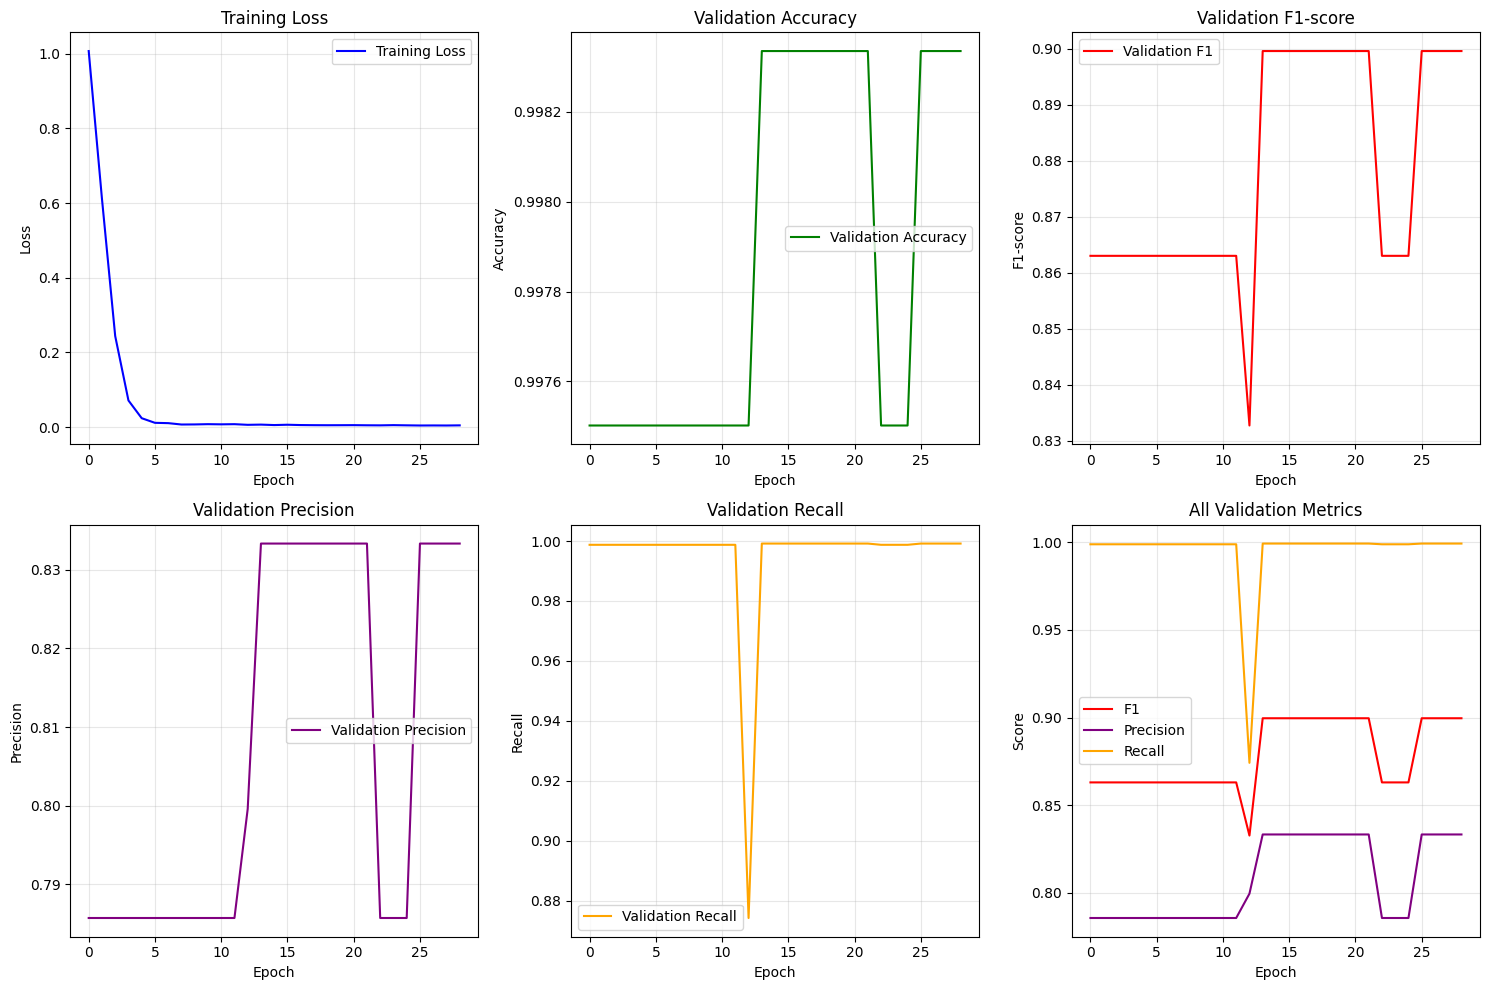

In [27]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(15, 10))

# График Loss
plt.subplot(2, 3, 1)
plt.plot(metrics_history['train_loss'], label='Training Loss', color='blue')
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(alpha=0.3)
plt.legend()

# График Accuracy
plt.subplot(2, 3, 2)
plt.plot(metrics_history['val_acc'], label='Validation Accuracy', color='green')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.legend()

# График F1-score
plt.subplot(2, 3, 3)
plt.plot(metrics_history['val_f1'], label='Validation F1', color='red')
plt.title('Validation F1-score')
plt.xlabel('Epoch')
plt.ylabel('F1-score')
plt.grid(alpha=0.3)
plt.legend()

# График Precision
plt.subplot(2, 3, 4)
plt.plot(metrics_history['val_precision'], label='Validation Precision', color='purple')
plt.title('Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.grid(alpha=0.3)
plt.legend()

# График Recall
plt.subplot(2, 3, 5)
plt.plot(metrics_history['val_recall'], label='Validation Recall', color='orange')
plt.title('Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.grid(alpha=0.3)
plt.legend()

# Объединённый график метрик
plt.subplot(2, 3, 6)
plt.plot(metrics_history['val_f1'], label='F1', color='red')
plt.plot(metrics_history['val_precision'], label='Precision', color='purple')
plt.plot(metrics_history['val_recall'], label='Recall', color='orange')
plt.title('All Validation Metrics')
plt.xlabel('Epoch')
plt.ylabel('Score')
plt.grid(alpha=0.3)
plt.legend()

plt.tight_layout()
plt.show()

## 9. Тестирование

### 9.1 Загрузка лучшей модели для инференса

In [28]:
def load_best_model(model, device='cuda'):
    model.load_state_dict(torch.load('best_model/best_model.pth', map_location=device))
    model.eval()
    return model

# Инициализация новой модели
new_model = EdgeEnhancedGCN(1, 64, 3).to(device)
#new_optimizer = torch.optim.Adam(new_model.parameters(), lr=0.005)

# Загрузка лучшей модели для инференса
trained_model = load_best_model(new_model)

### 9.2. Пример предсказания для конкретного узла

In [29]:
def predict_node(node_idx, model, data, device='cuda'):
    model.eval()
    with torch.no_grad():
        # Получаем предсказания для всех узлов
        logits = model(
            data.x.to(device),
            data.edge_index.to(device),
            data.edge_attr.to(device)
        )
        # Выбираем предсказание для нужного узла
        prob = F.softmax(logits[node_idx], dim=-1)
    return f"Node {node_idx}: Class {prob.argmax().item()} (Confidence: {prob.max().item():.2f})"

In [30]:
# Пример предсказания для узла с индексом 7
print(predict_node(7, trained_model, data, device))

Node 7: Class 0 (Confidence: 0.71)


In [31]:
# Пример предсказания для нескольких узлов с индексами 3, 42, 100
for node_idx in [3, 42, 100]:
    print(predict_node(node_idx, trained_model, data, device))

Node 3: Class 2 (Confidence: 0.99)
Node 42: Class 0 (Confidence: 1.00)
Node 100: Class 0 (Confidence: 1.00)


### 9.3 Тестирование модели на лучших весах

In [32]:
model.eval()
with torch.no_grad():
    test_out = trained_model(data.x.to(device), data.edge_index.to(device), data.edge_attr.to(device))
    test_acc = accuracy(test_out, data.y.to(device), data.test_mask.to(device))
    print(f'Final Test Accuracy: {test_acc:.4f}')

Final Test Accuracy: 0.9983


## 10. Загрузка чекпоинта для продолжения обучения

In [33]:
# Функция загрузки чекпоинта
def load_checkpoint(model, optimizer, checkpoint_path):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state'])
    optimizer.load_state_dict(checkpoint['optimizer_state'])
    epoch = checkpoint['epoch']
    return model, optimizer, epoch

In [34]:
# Инициализация новой модели
new_model = EdgeEnhancedGCN(1, 64, 3).to(device)
new_optimizer = torch.optim.Adam(new_model.parameters(), lr=0.005)

In [35]:
# Загрузка чекпоинта для продолжения обучения
loaded_model, loaded_optimizer, start_epoch = load_checkpoint(
    new_model,
    new_optimizer,
    'checkpoints/checkpoint_epoch_0.pth'# последний сохраненный checkpoint
)
print(f'Resuming training from epoch {start_epoch}')

Resuming training from epoch 0


# 11. Возможные улучшения

- Добавление дополнительных признаков узлов
- Добавим Batch Normalization между слоями
- Экспериментируем с размером скрытого слоя
- Используем weighted loss для несбалансированных классов
- Подбор гиперпараметров через Optuna